# Goal

Develop a machine learning model for Zyfra, an efficiency solutions for heavy industry company. The model analyzes data on extraction and purification of gold from an ore and predicts the final amount of recovered gold. The goven data has problems.  Some features are present in the training, but not in the test set. Most importantly, test data does not include the two target variables. The final model is expected to optimize the production process.

# Data description

**Technological process**

- *Rougher feed* — raw material
- *Rougher additions* (or *reagent additions*) — flotation reagents: *Xanthate, Sulphate, Depressant*
    - *Xanthate* — promoter or flotation activator;
    - *Sulphate* — sodium sulphide for this particular process;
    - *Depressant* — sodium silicate.
- *Rougher process* — flotation
- *Rougher tails* — product residues
- *Float banks* — flotation unit
- *Cleaner process* — purification
- *Rougher Au* — rougher gold concentrate
- *Final Au* — final gold concentrate

**Parameters of stages**

- *air amount — volume of air*
- *fluid levels*
- *feed size* — feed particle size
- *feed rate*

# Feature names

Here's how we name the features:

`[stage].[parameter_type].[parameter_name]`

Example: `rougher.input.feed_ag`

Possible values for `[stage]`:

- *rougher —* flotation
- *primary_cleaner* — primary purification
- *secondary_cleaner* — secondary purification
- *final* — final characteristics

Possible values for `[parameter_type]`:

- *input* — raw material parameters
- *output* — product parameters
- *state* — parameters characterizing the current state of the stage
- *calculation —* calculation characteristics

# Package imports 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import statsmodels.api as sm
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler as ss
from sklearn.pipeline import Pipeline


from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.utils import *
from sklearn.dummy import *

/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Data imports

In [2]:
train = pd.read_csv('gold_recovery_train.csv', index_col='date')
test  = pd.read_csv('gold_recovery_test.csv', index_col='date')
full  = pd.read_csv('gold_recovery_full.csv', index_col='date')

Indexing date

# Understanding the data

In [3]:
def understand_df(df):
    rows_count, columns_count = df.shape
    print('Number of columns:', columns_count)
    print('Number of rows:', rows_count)
    print(df.isnull().mean().round(4).mul(100).sort_values(ascending=False).nlargest(15))
    display(df.head(1))
    print(df.dtypes.value_counts())

## Train dataframe

In [4]:
understand_df(train)

Number of columns: 86
Number of rows: 16860
rougher.output.recovery                   15.26
rougher.output.tail_ag                    13.35
rougher.output.tail_sol                   13.34
rougher.output.tail_au                    13.34
secondary_cleaner.output.tail_sol         11.78
rougher.input.floatbank11_xanthate        11.29
final.output.recovery                      9.02
primary_cleaner.input.sulfate              7.75
primary_cleaner.input.depressant           7.49
rougher.calculation.au_pb_ratio            7.37
rougher.input.floatbank10_sulfate          6.19
primary_cleaner.input.xanthate             5.84
primary_cleaner.output.concentrate_sol     3.77
rougher.input.floatbank11_sulfate          3.70
rougher.state.floatbank10_e_air            3.58
dtype: float64


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.19202,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.84198


float64    86
dtype: int64


### Conclusion: 
All 86 features are float; the number of observations is 16860; 10 out of the 86 features have missing values above 7%. 

## Test Dataframe

In [5]:
understand_df(test)

Number of columns: 52
Number of rows: 5856
rougher.input.floatbank11_xanthate          6.03
primary_cleaner.input.sulfate               5.16
primary_cleaner.input.depressant            4.85
rougher.input.floatbank10_sulfate           4.39
primary_cleaner.input.xanthate              2.83
rougher.input.floatbank10_xanthate          2.10
rougher.input.feed_sol                      1.14
rougher.input.floatbank11_sulfate           0.94
rougher.input.feed_rate                     0.68
secondary_cleaner.state.floatbank3_a_air    0.58
secondary_cleaner.state.floatbank2_b_air    0.39
rougher.input.feed_size                     0.38
secondary_cleaner.state.floatbank2_a_air    0.34
rougher.state.floatbank10_f_air             0.29
rougher.state.floatbank10_e_air             0.29
dtype: float64


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.31785,4.872511,-500.037437,26.705889,-499.709414


float64    52
dtype: int64


### Conclusion: 
All 52 features are float; the number of observations is 5856; no features have missing values above 7%. 

## Full Dataframe

In [6]:
understand_df(full)

Number of columns: 86
Number of rows: 22716
rougher.output.recovery                   13.73
rougher.output.tail_ag                    12.05
rougher.output.tail_sol                   12.04
rougher.output.tail_au                    12.04
rougher.input.floatbank11_xanthate         9.94
secondary_cleaner.output.tail_sol          9.75
final.output.recovery                      8.64
rougher.calculation.au_pb_ratio            7.16
primary_cleaner.input.sulfate              7.08
primary_cleaner.input.depressant           6.81
rougher.input.floatbank10_sulfate          5.73
primary_cleaner.input.xanthate             5.07
primary_cleaner.output.concentrate_sol     3.51
rougher.input.floatbank11_sulfate          2.98
rougher.state.floatbank10_e_air            2.73
dtype: float64


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.19202,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.84198


float64    86
dtype: int64


### Conclusion: 
All 86 features are float; the number of observations is 22716; 9 features have missing values above 7%. 

# Recovery calculation check

The MAE measures the average magnitude of the errors in a set of forecasts, without considering their direction. It measures accuracy for continuous variables.

In [7]:
C = train["rougher.output.concentrate_au"]
F = train["rougher.input.feed_au"]
T = train["rougher.output.tail_au"]

In [8]:
train["rougher.output.recovery.calculated"] = (C * (F - T)) / (F * (C - T)) * 100

In [9]:
mae = (train["rougher.output.recovery.calculated"] - train["rougher.output.recovery"]).abs().sum() / len(train)
print("MAE", ":", mae)

MAE : 7.883623897364653e-15


## Conclusion: 
The MAE is almost 0.  This means that the recovery was calculated properly when preparing the data.

# Missing features Analysis

Features available in the full dataset, but not in the test set.

In [10]:
diff = full.columns.difference(test.columns)

In [11]:
full[diff].info()

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_au                         22630 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_au                                22635 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                            

## Conclusion: 
There are 34 features missing from the test set.  The number of entries is 22716 which corresponds to the full dataset.  It is important to note that all these features are either outputs of the process or calculations based on those outputs, thus we can't use them in our models.  As a result, the full dataset is in some way redundant.

# Data Preprocessing

Our target is ['final.output.recovery', 'rougher.output.recovery']

## Recover targets

Let's use the full dataset to extract test targets and include them in the test set to be able to compare our predictions to the actual values.

In [12]:
test_merged = test.merge(full[['final.output.recovery', 'rougher.output.recovery']], how='left', left_index=True, right_index=True)

In [13]:
understand_df(test_merged)

Number of columns: 54
Number of rows: 5856
rougher.output.recovery                     9.32
final.output.recovery                       7.55
rougher.input.floatbank11_xanthate          6.03
primary_cleaner.input.sulfate               5.16
primary_cleaner.input.depressant            4.85
rougher.input.floatbank10_sulfate           4.39
primary_cleaner.input.xanthate              2.83
rougher.input.floatbank10_xanthate          2.10
rougher.input.feed_sol                      1.14
rougher.input.floatbank11_sulfate           0.94
rougher.input.feed_rate                     0.68
secondary_cleaner.state.floatbank3_a_air    0.58
secondary_cleaner.state.floatbank2_b_air    0.39
rougher.input.feed_size                     0.38
secondary_cleaner.state.floatbank2_a_air    0.34
dtype: float64


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.31785,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421


float64    54
dtype: int64


### The test_merged set still has 5856 rows, but now has 54 features.  But our target features have more missing variables than the rest of the features.

## Duplicates

Let's check if any rows are duplicated.

In [14]:
test_merged.duplicated().sum()

6

In [15]:
test_merged = test_merged.drop_duplicates()

# EDA

## Concentrations of metals

Using the full dataset

In [16]:
# This function takes two arguments: a dataframe and a string.  It extracts columns from the dataframe that indlucde the  
# specific string passed as argument. It returns a dataframe these columns.

def metal_specific(df, string):
    cols = [col for col in df.columns if string in col]
    return df[cols]

In [17]:
# This function takes four arguments: the dataframe, the type of metal, its raw feed, rougher concentrate, and final 
# concentrate. It then extracts a specific metal and takes its mean at a specificc stage of processing

def various_stages(df, metal, raw, rougher, final):
    
    stages = metal_specific(train,metal)
    stages = metal_specific(stages,raw)
    stages = metal_specific(stages,rougher)
    stages = metal_specific(stages,final)
    mean = stages.mean()
    return mean[0]

In [18]:
#vectors of elements
au_rougher_feed_input = various_stages(full,'au','rougher','feed', 'input')
ag_rougher_feed_input = various_stages(full,'ag','rougher','feed', 'input')
pb_rougher_feed_input = various_stages(full,'pb','rougher','feed', 'input')
au_final_output_tail = various_stages(full,'au','final','output', 'tail')
ag_final_output_tail = various_stages(full,'ag','final','output', 'tail')
pb_final_output_tail = various_stages(full,'pb','final','output', 'tail')
au_rougher_output_tail = various_stages(full,'au','rougher','output', 'tail')
ag_rougher_output_tail = various_stages(full,'ag','rougher','output', 'tail')
pb_rougher_output_tail = various_stages(full,'pb','rougher','output', 'tail')
au_primary_output_concentrate = various_stages(full,'au','primary','output','concentrate')
ag_primary_output_concentrate = various_stages(full,'ag','primary','output','concentrate')
pb_primary_output_concentrate = various_stages(full,'pb','final','output','concentrate')
au_final_output_concentrate = various_stages(full,'au','final','output','concentrate')
ag_final_output_concentrate = various_stages(full,'ag','final','output','concentrate')
pb_final_output_concentrate = various_stages(full,'pb','final','output','concentrate')

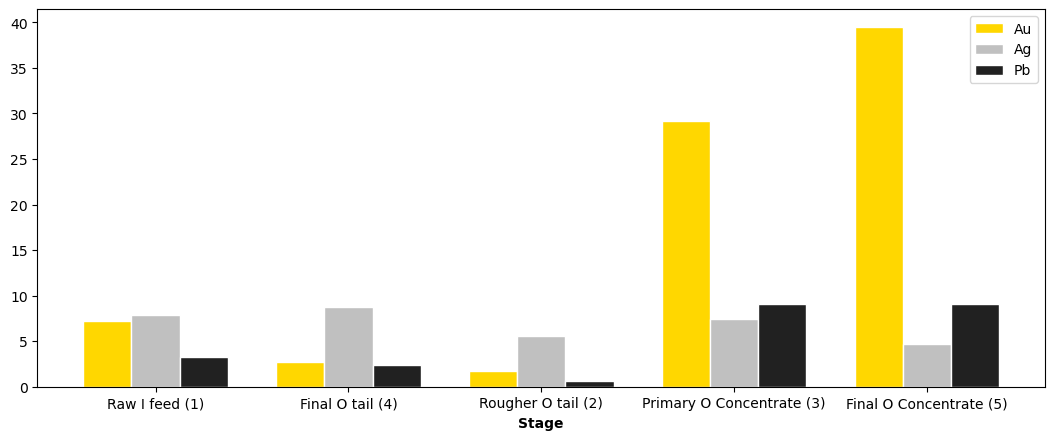

In [19]:
plt.figure(figsize = (13,5), dpi = 100, facecolor = 'w', edgecolor = 'k')

labels = ['Au', 'Ag', 'Pb']

bars1 = [au_rougher_feed_input, 
         au_final_output_tail,
         au_rougher_output_tail, 
         au_primary_output_concentrate, 
         au_final_output_concentrate]

bars2 = [ag_rougher_feed_input, 
         ag_final_output_tail,
         ag_rougher_output_tail, 
         ag_primary_output_concentrate, 
         ag_final_output_concentrate]

bars3 = [pb_rougher_feed_input, 
         pb_final_output_tail,
         pb_rougher_output_tail, 
         pb_primary_output_concentrate, 
         pb_final_output_concentrate]

barWidth = 0.25

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#FFD700', width=barWidth, edgecolor='white', label='Au')
plt.bar(r2, bars2, color='#C0C0C0', width=barWidth, edgecolor='white', label='Ag')
plt.bar(r3, bars3, color='#212121', width=barWidth, edgecolor='white', label='Pb')
 
# Add xticks on the middle of the group bars
plt.xlabel('Stage', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], 
           ['Raw I feed (1)', 
            'Final O tail (4)', 
            'Rougher O tail (2)',
            'Primary O Concentrate (3)', 
            'Final O Concentrate (5)'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

### Conclusion:  
The process seems efficient as it starts with little raw and looses just a little more in the process while the output concentrates are high, most specifically for gold.

## Feed particle size distributions 

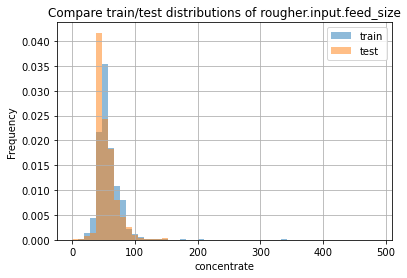

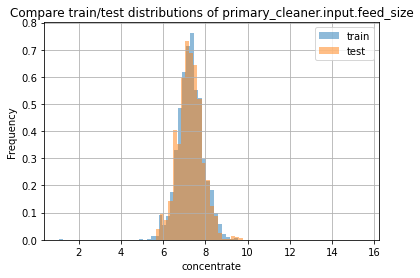

In [20]:
for i in ('rougher.input.feed_size', 'primary_cleaner.input.feed_size'):
    for j, df in (('train', train), ('test', test)): 
        df[i].plot(
                title = 'Compare train/test distributions of {}'.format(i),
                kind='hist', 
                grid=True, 
                bins = 50,
                density=True,
                legend=True,
                alpha=0.5,
                label=j
            ).set(xlabel='concentrate')
    plt.show()

### Conclusion:
These distributions for the training and testing sets are kind of similar.  We have few outliers.


The symmetric mean absolute percentage error (sMAPE) is an accuracy measure based on percentage (or relative) errors. Relative error is the absolute error divided by the magnitude of the exact value. In contrast to the mean absolute percentage error, sMAPE has both a lower bound and an upper bound

## Total concentrations at different stages

Using the full dataset, we analyze total concentrations of metals at three different states.  For that, I create a new df called total

In [21]:
def raw_feed(df):
    return df["rougher.input.feed_au"] + df["rougher.input.feed_ag"] + df["rougher.input.feed_pb"] + df["rougher.input.feed_sol"]

In [22]:
def rougher_concentrate(df):
    return df["rougher.output.concentrate_au"] + df["rougher.output.concentrate_ag"] + df["rougher.output.concentrate_pb"] + df["rougher.output.concentrate_sol"]

In [23]:
def final_concentrate(df):
    return df["final.output.concentrate_au"] + df["final.output.concentrate_ag"] + df["final.output.concentrate_pb"] + df["final.output.concentrate_sol"]

In [24]:
full["raw.feed"] = raw_feed(full)
full["rougher.concentrate"] = rougher_concentrate(full)
full["final.concentrate"] = final_concentrate(full)
total = full[["raw.feed", "rougher.concentrate", "final.concentrate"]]

In [25]:
total.head()

,raw.feed,rougher.concentrate,final.concentrate
date,,,
2016-01-15 00:00:00,51.680034,66.424950,63.644396
2016-01-15 01:00:00,50.659114,67.012710,63.957723
2016-01-15 02:00:00,50.609929,66.103793,64.311180
2016-01-15 03:00:00,51.061546,65.752751,63.573449
2016-01-15 04:00:00,47.859163,65.908382,64.004667


### Visualize

/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

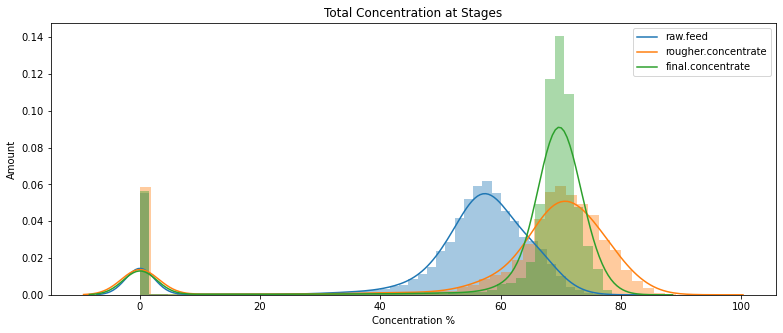

In [26]:
fig = plt.figure(figsize=(13, 5))
for column in list(total):
    sns.distplot(total[column])
plt.legend(list(total))
plt.title("Total Concentration at Stages")
plt.xlabel("Concentration %")
plt.ylabel("Amount")
fig.show();

Lets have a closer look at these outliers

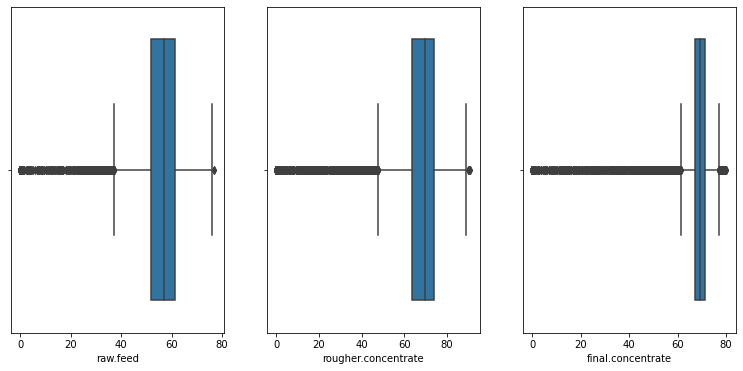

In [27]:
columns = ["raw.feed", "rougher.concentrate", "final.concentrate"]

_, axs = plt.subplots(1,3, figsize=(13, 6))


for column, ax in zip(columns, axs):
    sns.boxplot(x = column, data = total, ax = ax)

### Conclusion: 
These concentrations have outliers.

### Missing values

#### Removing outliers from the train df

In [28]:
train["raw.feed"] = raw_feed(train)
train["rougher.concentrate"] = rougher_concentrate(train)
train["final.concentrate"] = final_concentrate(train)

In [29]:
Q1 = train[columns].quantile(0.25)
Q3 = train[columns].quantile(0.75)
IQR = Q3 - Q1

train_final = train[~((train[columns] < (Q1 - 1.5 * IQR)) |(train[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

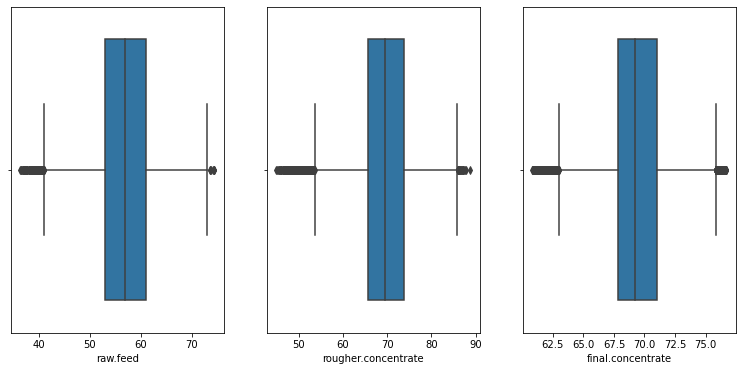

In [30]:
_, axs = plt.subplots(1,3, figsize=(13, 6))


for column, ax in zip(columns, axs):
    sns.boxplot(x = column, data = train_final, ax = ax)

## Target data

### In Training

In [31]:
understand_df(train_final)

Number of columns: 90
Number of rows: 13598
secondary_cleaner.output.tail_sol           12.19
rougher.output.recovery                      4.21
rougher.output.tail_ag                       4.06
rougher.output.tail_au                       4.05
rougher.output.tail_sol                      4.05
rougher.output.recovery.calculated           4.05
rougher.input.floatbank11_xanthate           3.10
rougher.state.floatbank10_e_air              2.90
primary_cleaner.output.concentrate_sol       2.27
final.concentrate                            2.22
final.output.concentrate_sol                 2.21
raw.feed                                     1.92
secondary_cleaner.state.floatbank2_a_air     1.88
rougher.input.feed_pb                        1.40
rougher.input.feed_size                      1.35
dtype: float64


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery.calculated,raw.feed,rougher.concentrate,final.concentrate
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.19202,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.84198,87.107763,51.680034,66.42495,63.644396


float64    90
dtype: int64


#### Conclusion: 
The rougher.output.recovery has 4.21\% missing values and the final.output.recovery  0.79\%

### In Testing

In [32]:
understand_df(test_merged)

Number of columns: 54
Number of rows: 5850
rougher.output.recovery                     9.23
final.output.recovery                       7.45
rougher.input.floatbank11_xanthate          5.93
primary_cleaner.input.sulfate               5.06
primary_cleaner.input.depressant            4.75
rougher.input.floatbank10_sulfate           4.29
primary_cleaner.input.xanthate              2.74
rougher.input.floatbank10_xanthate          2.00
rougher.input.feed_sol                      1.04
rougher.input.floatbank11_sulfate           0.84
rougher.input.feed_rate                     0.58
secondary_cleaner.state.floatbank3_a_air    0.48
secondary_cleaner.state.floatbank2_b_air    0.29
rougher.input.feed_size                     0.27
secondary_cleaner.state.floatbank2_a_air    0.24
dtype: float64


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.31785,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421


float64    54
dtype: int64


#### Conclusion: 
The rougher.output.recovery 9.23\% while the final.output.recovery 7.45\%

### Fill missing value

Let's fill missing data using nearest values strategy - ffill, because our gathering of our data relates to datetime 

In [33]:
train_final = train_final[~train_final['final.output.recovery'].isna()]
train_final = train_final[~train_final['rougher.output.recovery'].isna()]
train_final = train_final.fillna(method='ffill')

In [34]:
test_merged = test_merged[~test_merged['final.output.recovery'].isna()]
test_merged = test_merged[~test_merged['rougher.output.recovery'].isna()]
test_merged = test_merged.fillna(method='ffill')

#### Conclusion: 
The number of features is different.

### Visualize

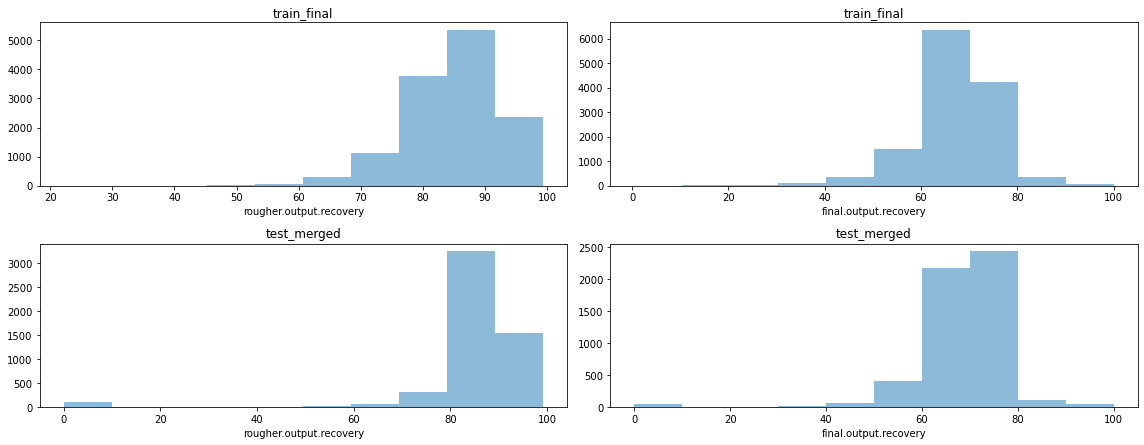

In [35]:
targets = ['rougher.output.recovery', 'final.output.recovery']
dfs = [train_final, test_merged]
train_final.name = 'train_final'
test_merged.name = 'test_merged'

plt.figure(figsize=(16,12))
c=1
for i, df in enumerate(dfs):
    for target in targets:
        plt.subplot(4,2,c)
        plt.hist(df[target], alpha=.5)
        plt.title(df.name)
        plt.xlabel(target)
        c = c + 1
plt.tight_layout()

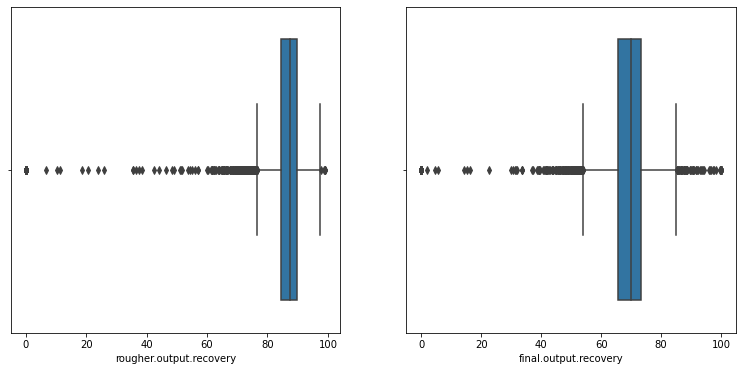

In [36]:
_, axs = plt.subplots(1,2, figsize=(13, 6))


for column, ax in zip(targets, axs):
    sns.boxplot(x = column, data = test_merged, ax = ax)

#### Remove outliers

##### from testing data

In [37]:
Q1 = test_merged[targets].quantile(0.25)
Q3 = test_merged[targets].quantile(0.75)
IQR = Q3 - Q1

test_merged = test_merged[~((test_merged[targets] < (Q1 - 1.5 * IQR)) |(test_merged[targets] > (Q3 + 1.5 * IQR))).any(axis=1)]

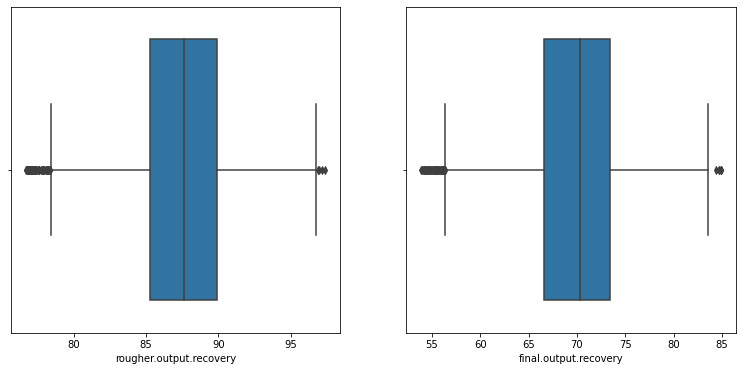

In [38]:
_, axs = plt.subplots(1,2, figsize=(13, 6))


for column, ax in zip(targets, axs):
    sns.boxplot(x = column, data = test_merged, ax = ax)

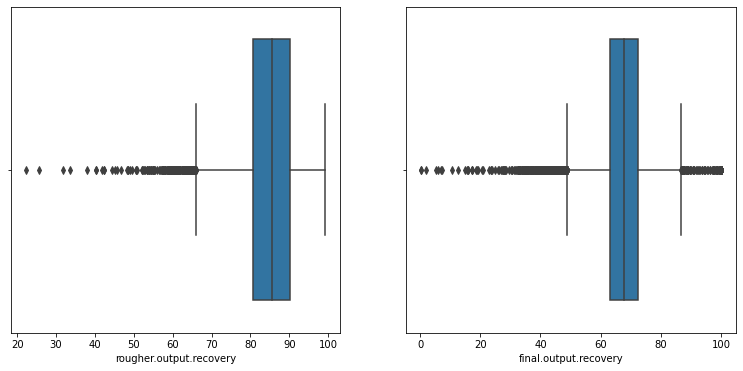

In [39]:
_, axs = plt.subplots(1,2, figsize=(13, 6))


for column, ax in zip(targets, axs):
    sns.boxplot(x = column, data = train_final, ax = ax)

##### from Training data

In [40]:
Q1 = train_final[targets].quantile(0.25)
Q3 = train_final[targets].quantile(0.75)
IQR = Q3 - Q1

train_final = train_final[~((train_final[targets] < (Q1 - 1.5 * IQR)) |(train_final[targets] > (Q3 + 1.5 * IQR))).any(axis=1)]

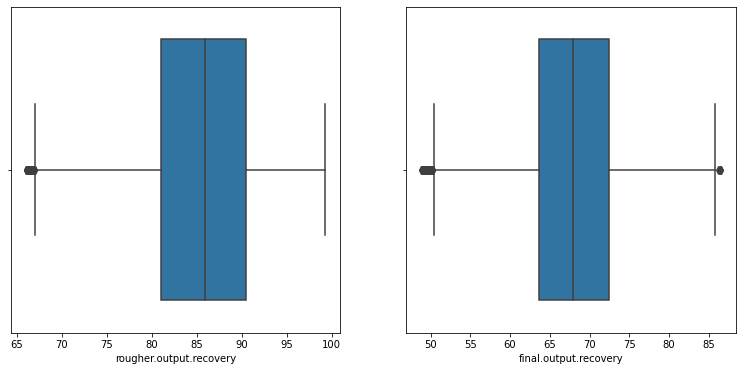

In [41]:
_, axs = plt.subplots(1,2, figsize=(13, 6))


for column, ax in zip(targets, axs):
    sns.boxplot(x = column, data = train_final, ax = ax)

Our final sets are train_final and test_merged

# Scorers: sMAPE and Final sMAPE

In [42]:
def smape(y_test, y_pred):
     return (np.abs(y_test-y_pred)/((np.abs(y_test) + np.abs(y_pred))/2)).mean()

In [43]:
def smape_final(y_test,y_pred):
    smape_rougher = smape(y_test[:,0], y_pred[:,0])
    smape_final = smape(y_test[:,1], y_pred[:,1])
    return 0.25*smape_rougher + 0.75*smape_final

# Prepare the data

## Features and target

In [44]:
target = ['rougher.output.recovery', 'final.output.recovery']
features = list(set(train_final.columns).intersection(set(test_merged.columns)).difference(set(target)))

## Split the data

In [45]:
X_train, X_test = train_final[features].values, test_merged[features].values
y_train, y_test = train_final[target].values, test_merged[target].values

## Scorer

In [46]:
smape_scorer = make_scorer(smape_final, greater_is_better=False)

# Models

## Dummy

In [47]:
dm_mean = DummyRegressor(strategy='mean').fit(X_train, y_train)
y_pred_mean = dm_mean.predict(X_test)
print('smape:', smape_final(y_test, y_pred_mean))

smape: 0.05941562183025197


In [48]:
dm_median = DummyRegressor(strategy='median').fit(X_train, y_train)
y_pred_median = dm_median.predict(X_test)
print('smape:', smape_final(y_test, y_pred_median))

smape: 0.05855362372942582


## Linear Regression

In [49]:
lr = LinearRegression().fit(X_train, y_train)
scores_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring=smape_scorer)
scores_lr
print("mean smape:", np.abs(scores_lr.mean()))

mean smape: 0.0743916340137412


## Decision Tree

In [50]:
params = {'min_samples_split': range(2, 10, 2), 'max_depth': range(4,8,2)}
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=12345),param_grid=params,scoring=smape_scorer, cv=5, refit=True)
g_cv.fit(X_train, y_train)
best_params = g_cv.best_params_
dtr = DecisionTreeRegressor(**best_params).fit(X_train, y_train)
scores_dtr = cross_val_score(dtr, X_train, y_train, cv=5, scoring=smape_scorer)
scores_dtr
print("mean smape:", np.abs(scores_dtr.mean()))

mean smape: 0.0747827462179225


## Lasso

In [51]:
params = {'alpha': range(0,1), 'tol':  range(0, 1), 'max_iter': range (10, 20, 30)}
lasso_cv = GridSearchCV(linear_model.Lasso(random_state=12345),param_grid=params,scoring=smape_scorer, cv=5, refit=True)
lasso_cv.fit(X_train, y_train)
best_params = lasso_cv.best_params_
lasso = linear_model.Lasso(**best_params).fit(X_train, y_train)
scores_lasso = cross_val_score(lasso, X_train, y_train, cv=5, scoring=smape_scorer)
scores_lasso
print("mean smape:", np.abs(scores_lasso.mean()))

/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.472e+04, tolerance: 0.000e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.

mean smape: 0.07213996288295794


/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.944e+04, tolerance: 0.000e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.

## Random Forest

In [52]:
params = {'min_samples_split': range(2, 6, 2)}
rf_cv = GridSearchCV(RandomForestRegressor(random_state=12345),param_grid=params,scoring=smape_scorer, cv=5, refit=True)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
rfr = RandomForestRegressor(**best_params).fit(X_train, y_train)
scores_rfr = cross_val_score(rfr, X_train, y_train, cv=5, scoring=smape_scorer)
scores_rfr
print("mean smape:", np.abs(scores_rfr.mean()))

mean smape: 0.0689076903952549


### Conclusion: 

We developed, tuned and tested models. The dummy models have the best sMAPE.  If I were to chose from the other model after cross-validation I would reluctantly choose the random forest.  Below is the performance of the random forest on the test set.  This performance is still outperformed by the dummy models

In [53]:
y_pred_rfr = rfr.predict(X_test)
smape_final(y_test, y_pred_rfr)

0.06043298006460345

#### The sMAPE on the test set confirms my doubt that there is not a good model for this dataset that outperforms the dummies.

# Project Conclusion:
- I conducted an MAE check from the recovery calculation and found that my results and those in the dataset coincided.
- I conducted a missing feature analysis and
- In preprocessing data, I recovered the target into the test data from the full dataset and checked for duplicates
- I then conducted an EDA on:
    - the concentration of metal and found that the process is efficient because the rougher tails are small at each stage and the concentrates increase as the ore reaches the final stages.
    - feed particle size normal-ish and the same for both the train and test sets
    - total concentrations at different stages had much outliers.  Those were removed using the 3 standard deviation rule
    - The two target variables: I filled the missing values and removed the outliers in both the test and train sets
- Finally, I developed the sMAPE scorer and split the data into features and target.  I ran various ML models and found that the dummy outperformed each one of them